In [1]:
import keras
from keras.applications import DenseNet169 #DenseNet121, DenseNet169, DenseNet201, ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from label2onehot import label2onehot
from onehot2label import onehot2label
from label_dict import label_dict
import gc

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Use GPU
config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 4}, log_device_placement=True ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
#Import train set
x = np.load('train_crop.npy')/255.
y_label = np.load('train.npy')

In [4]:
#Convert label to onehot
#onehot_y = label2onehot(y[:, 0], 256)
#np.save('onehot_y_train.npy',onehot_y)
#from keras.utils.np_utils import to_categorical
#y = to_categorical(y_label[:,0], num_classes=256)
y = y_label[:,0]

In [5]:
#Build the new model based on DenseNet121
def getmodel(num_classes=256):
    '''
    Build the new model based on DenseNet121, DenseNet169, DenseNet201
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    
    orig_model = DenseNet169(include_top=False, weights='imagenet', pooling='avg', classes=num_classes)
    densenet_out = orig_model.layers[-1].output
    out = Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(densenet_out)
    model = Model(input=orig_model.input, output=out)
    model.compile(loss= "sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [6]:
densemodel = getmodel(256)
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="DenseNet169_transfer_crop.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history = densemodel.fit(x, y, epochs=15, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()


Train on 17868 samples, validate on 5956 samples
Epoch 1/15
17868/17868 [==============================] - 277s 16ms/step - loss: 3.1700 - acc: 0.3339 - val_loss: 3.4268 - val_acc: 0.3066

Epoch 00001: val_acc improved from -inf to 0.30658, saving model to DenseNet169_transfer_crop.hdf5
Epoch 2/15
17868/17868 [==============================] - 259s 14ms/step - loss: 1.7981 - acc: 0.5671 - val_loss: 3.1033 - val_acc: 0.3895

Epoch 00002: val_acc improved from 0.30658 to 0.38952, saving model to DenseNet169_transfer_crop.hdf5
Epoch 3/15
17868/17868 [==============================] - 262s 15ms/step - loss: 1.2635 - acc: 0.6787 - val_loss: 2.2833 - val_acc: 0.5185

Epoch 00003: val_acc improved from 0.38952 to 0.51847, saving model to DenseNet169_transfer_crop.hdf5
Epoch 4/15
17868/17868 [==============================] - 262s 15ms/step - loss: 0.8981 - acc: 0.7605 - val_loss: 2.2030 - val_acc: 0.5479

Epoch 00004: val_acc improved from 0.51847 to 0.54785, saving model to DenseNet169_trans

In [7]:
#release RAM
del x, y
gc.collect()

18422

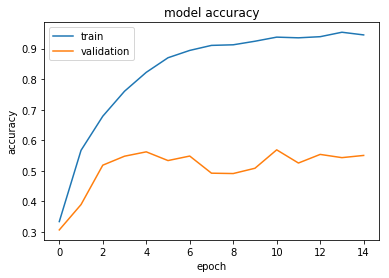

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

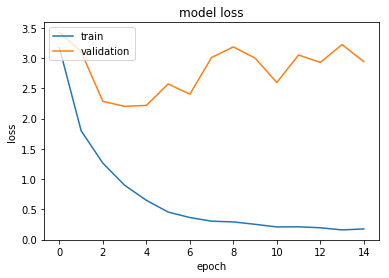

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
#Import test dataset
X_test = np.load('test_crop.npy')/255.
Y_test = np.load('onehot_y_test.npy')
y_test = np.load('test.npy')

In [11]:
##Convert label to onehot
#y_test = label2onehot(Y_test[:, 0], 256)
#np.save('onehot_y_test.npy', y_test)

In [12]:
densemodel.load_weights('DenseNet169_transfer_crop.hdf5')

In [13]:
#evaluate
eva = densemodel.evaluate(X_test, y_test[:, 0], batch_size=32, verbose=1, sample_weight=None)
print()
print("Loss = " + str(eva[0]))
print("Test Accuracy = " + str(eva[1]))

5956/5956 [==============================] - 34s 6ms/step
()
Loss = 2.580181831157472
Test Accuracy = 0.5735392881128274


This image is: covered-wagon
The dict_label of image is: 50


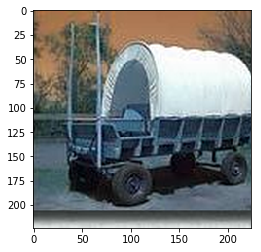

In [14]:
#predict a new image
predict_num = 2500
dict_label = label_dict()
X_predict = X_test[predict_num]
print('This image is: ' + dict_label[y_test[:, 0][predict_num]+1])
print('The dict_label of image is: '+str(y_test[:, 0][predict_num]+1))
plt.imshow(X_predict)

In [15]:
#predict
predict_vector = densemodel.predict(np.expand_dims(X_predict, axis=0))
index = np.where(predict_vector[0] == np.max(predict_vector[0]))
print('The predict dict_label of image is: '+str(index[0][0]+1))
print('The predict probability of image is: '+str(predict_vector[0, index[0][0]]))
print('This image is: ' + dict_label[index[0][0] + 1])

The predict dict_label of image is: 50
The predict probability of image is: 0.9963552
This image is: covered-wagon
